# PART 0: OMG check out this incredible TREND!!!! You won't believe your eyes.

# PART 0.0 : Cleaning the dataframes and normalising them.

In [2]:
#import usefull libraries
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


In [3]:
#import data

DATA_FOLDER = 'Data/'

INTERVENTIONS_DATASET = DATA_FOLDER+"interventions.csv"
TOPICS_LINKED_DATASET = DATA_FOLDER+"topics_linked.csv"
GLOBAL_MOBILITY_DATASET = DATA_FOLDER+"Global_Mobility_Report.csv"
APPLE_MOBILITY_DATASET = DATA_FOLDER+"applemobilitytrends-2020-04-20.csv"
TIMESERIES_DATASET = DATA_FOLDER+"aggregated_timeseries.json.gz"

### Downloading Mobility Data to get lockdown dates

In [4]:

from datetime import datetime
def intervention_date(intervention_data, intervention_event):
    year  = int(intervention_data[intervention_event][0:4])
    month = int(intervention_data[intervention_event][5:7])
    day   = int(intervention_data[intervention_event][8:10])
    date  = datetime(year, month, day)
    return date

interventions = pd.read_csv(DATA_FOLDER +"interventions.csv")
interventions_en= interventions.iloc[12]
#beggining of lockdown 2020-03-16
treatment_start_date = intervention_date(interventions_en, "Mobility") #
 # Back to normal 2020-05-21
treatment_end_date = intervention_date(interventions_en, "Normalcy")


## Import wikipedia sum of english article for period 01-01-2020 to 30-06-2020

Then get the percentage of increase of 2020 wikipedia article compared to 2018.
To do that we do the difference between the views in 2020 and 2018 then the divide the by the average daily value of article in 2018.

for example to know the increase in views of wikipedia article for the 15th february 2020.
We do : Views(15 february 2020) - Views(15th february2018) /Average daily Views = x%

$$ \text{Percentage of Increase 15 February 2020} = \frac{\text{Views}(({\text{15th February 2020}}) - \text{Views}(({\text{15th February 2018}})}{\text{Average Daily Views}}$$

Then we plot the increase in views.




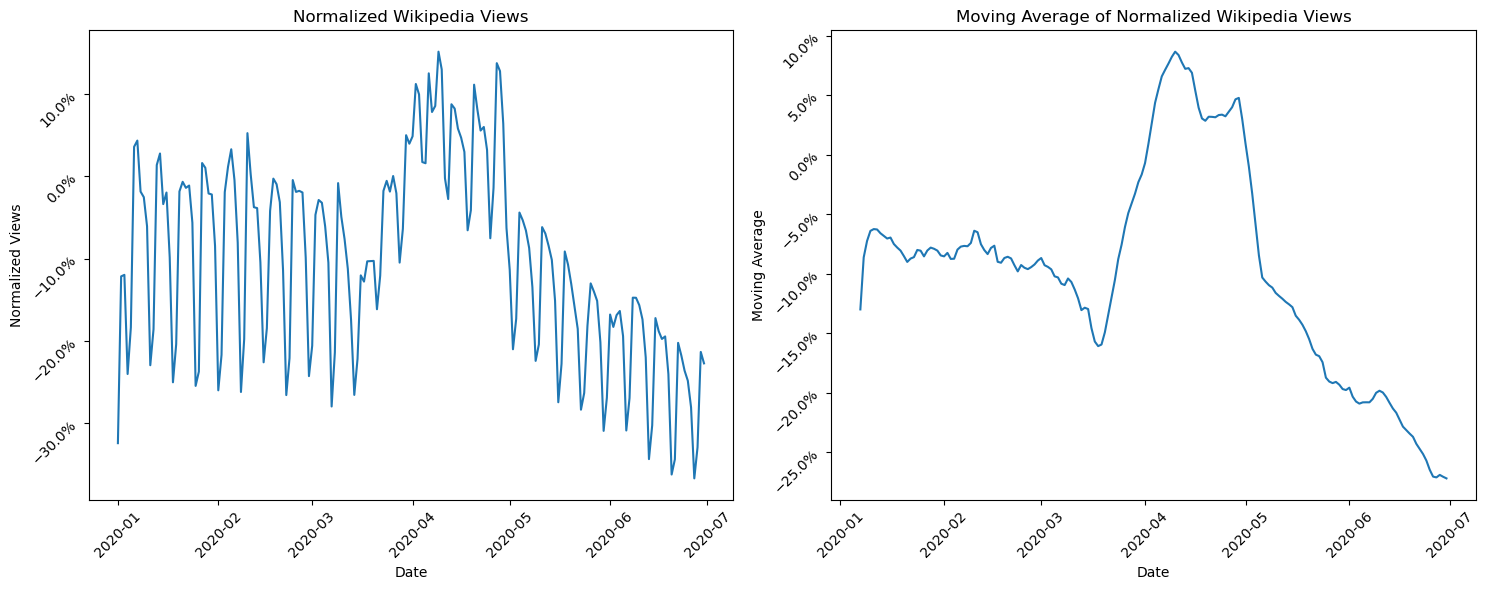

In [314]:
agg = pd.read_json(TIMESERIES_DATASET, compression='gzip')

#take english wikipedia articles
second_row = agg[['en']].iloc[1]
df = pd.DataFrame(second_row)
dic = df['sum'].iloc[0]

# Transform dic into a DataFrame
df = pd.DataFrame.from_dict(dic, orient='index', columns=['sum'])
df.reset_index(inplace=True)
df.columns = ['date', 'sum']

# Transform the date column to datetime
df['date'] = pd.to_datetime(df['date'])


# Needed dates
start_jan_2018 = '2018-01-01'
end_june_2018 = '2018-06-30'
start_jan_2020 = '2020-01-01'
end_june_2020 = '2020-06-30'


#period between 2018-01-01 and 2018-31-12

mask_2018 = (df['date'] >= start_jan_2018) & (df['date'] <= end_june_2018)
df_wiki_2018 = df.loc[mask_2018]
df_wiki_2018.reset_index(drop=True, inplace=True)

#period between 2020-01-01 and 2020-06-30
mask_2020 = (df['date'] >= start_jan_2020) & (df['date'] <= end_june_2020)
df_wiki_2020 = df.loc[mask_2020]
df_wiki_2020.reset_index(drop=True, inplace=True)

#distance to normality off 2020 wiki compared to average values of 2018
mean_wiki_sum = df_wiki_2018['sum'].mean()
normw = ((df_wiki_2020['sum'] - mean_wiki_sum) / mean_wiki_sum)
df_wiki_dist_norm = df_wiki_2020.copy()
df_wiki_dist_norm['sum'] = normw
df_wiki_dist_norm.rename(columns={'sum': 'norm'}, inplace=True)
df_wiki_dist_norm['date'] = pd.to_datetime(df_wiki_2020['date'])
df_wiki_dist_norm = df_wiki_dist_norm.reset_index(drop=True)



# Plot the moving average
window_size = 7  # Define the window size for the moving average
df_wiki_dist_norm['moving_average'] = df_wiki_dist_norm['norm'].rolling(window=window_size).mean()




import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot normalized Wikipedia views
axs[0].plot(df_wiki_dist_norm['date'], df_wiki_dist_norm['norm'])
axs[0].set_title('Normalized Wikipedia Views')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Normalized Views')
axs[0].tick_params(rotation=45)

# Format the y-axis tick labels as percentages with 1 decimal place
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))

# Plot moving average of normalized Wikipedia views
axs[1].plot(df_wiki_dist_norm['date'], df_wiki_dist_norm['moving_average'])
axs[1].set_title('Moving Average of Normalized Wikipedia Views')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Moving Average')
axs[1].tick_params(rotation=45)

# Format the y-axis tick labels as percentages with 1 decimal place
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))

plt.tight_layout()
plt.show()


### Import wikipedia fake news articles and get the view count for each article

In [151]:
excel_file_path = 'Data/realFakeNewsNotLikeVictorsRealShy2.xlsx'

# Correspond to around 320 articles
new_res = pd.read_excel(excel_file_path)

#rename column
new_res.rename(columns={'name': 'Linked_Article'}, inplace=True)

new_res = new_res.drop_duplicates()
new_res.reset_index()

#remove the date for the articles that have a date next to the title
new_res.Linked_Article= new_res.Linked_Article.apply(clean_article_name)

#Fetch the view count for all available articles
language = "en"
combined_df = fetch_and_combine_pageview_data(language, new_res)

Error fetching dateee for Global_catastrophe_scenarios. Status Code: 404
Error fetching dateee for Urban_legends_and_myths. Status Code: 404
Error fetching dateee for Machiavellianism_. Status Code: 404
Error fetching dateee for Modern_flat_Earth_beliefs. Status Code: 404
Error fetching dateee for Lake_Michigan_Triangle. Status Code: 404
Error fetching dateee for Die_Glocke_. Status Code: 404
Error fetching dateee for Dundy_County_UFO_hoax. Status Code: 404
Error fetching dateee for Twin_Falls_saucer_hoax. Status Code: 404
Error fetching dateee for Aztec,_New_Mexico_crashed_saucer_hoax. Status Code: 404
Error fetching dateee for Alien_Autopsy_. Status Code: 404
Error fetching dateee for Killing_of_Johnny_Stompanato. Status Code: 404
Error fetching dateee for Conspiracy_theories_about_the_kidnapping_and_murder_of_Aldo_Moro. Status Code: 404
Error fetching dateee for Conspiracy_theories_about_the_death_of_Diana,_Princess_of_Wales. Status Code: 404
Error fetching dateee for Alejandro_Cast

Aggregate the dataset by categories to plot later on

Like previously, we want to get the increase in wikipedia fake news attention compared to the 2018 baseline and then get the percentage of increase of 2020 wikipedia fake news article compared to 2018. To do that we do the difference between the views in 2020 and 2018 then the divide the by the average daily value of views of the wikipedia fake news article of 2018.


In [120]:
#Create with article name and the view count in function of the date

combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
df_pivoted = combined_df.pivot_table(index='article', columns='timestamp', values='views', aggfunc='mean')

df_pivoted.reset_index(inplace=True)

#merge the data with the article with the corresponding ciews
merged_df = new_res.merge(df_pivoted, left_on='Linked_Article', right_on='article')
merged_df.drop(['subCategory','article' ],axis = 1, inplace=True)

#fill na with 0 
merged_df.fillna(0, inplace=True)

row_sums = merged_df.iloc[:, 2:].sum(axis=1)

# Add the row sums as a new column to the DataFrame 
merged_df['Row_Sums'] = row_sums

Final_consp_sorted = merged_df.sort_values(by='Row_Sums', ascending=False)
#Drop category overview wich is not very relevant
df_without_overview = Final_consp_sorted[Final_consp_sorted['mainCategory'] != 'Overview']


#aggregate data and categories and drop Linked articles
aggregated_data = df_without_overview.groupby('mainCategory').sum()
aggregated_data.drop('Linked_Article',axis=1, inplace=True)


# Sum values along rows (axis=1)
row_sums = aggregated_data.sum(axis=1)

# Identify the index of the 'Health' category
health_category_index = aggregated_data.index.get_loc('Health')

#Create with article name and the view count in function of the date

df_pivoted = combined_df.pivot_table(index='article', columns='timestamp', values='views', aggfunc='mean')

df_pivoted.reset_index(inplace=True)

#merge the data with the article with the corresponding ciews
merged_df = new_res.merge(df_pivoted, left_on='Linked_Article', right_on='article')
merged_df.drop(['subCategory','article' ],axis = 1, inplace=True)

#fill na with 0 
merged_df.fillna(0, inplace=True)

row_sums = merged_df.iloc[:, 2:].sum(axis=1)

# Add the row sums as a new column to the DataFrame 
merged_df['Row_Sums'] = row_sums

Final_consp_sorted = merged_df.sort_values(by='Row_Sums', ascending=False)
#Drop category overview wich is not very relevant
df_without_overview = Final_consp_sorted[Final_consp_sorted['mainCategory'] != 'Overview']


#for this need to drop the article name and the main category
df_med = df_without_overview.drop(['Linked_Article', 'mainCategory'], axis=1)

agg_data_median = df_med.mean()
df_fake = agg_data_median.reset_index()
df_fake = df_fake.iloc[:-1]
df_fake.columns = ['date', 'sum']
df_fake['date'] = pd.to_datetime(df_fake['date'])
mask_2020 = (df_fake['date'] >= start_jan_2020) & (df_fake['date'] <= end_june_2020)
df_fake_2020 = df_fake.loc[mask_2020]

#distance to normality off 2020 wiki compared to average values of 2018
mask_2018 = (df_fake['date'] >= start_jan_2018) & (df_fake['date'] <= end_june_2018)
df_fake_2018 = df_fake.loc[mask_2018]

mean_fake_sum = df_fake_2018['sum'].mean()



#normalize the fake data with respect to the mean

mean_fake = df_fake_2018['sum'].mean()
normf= ((df_fake_2020['sum']- mean_fake)/ mean_fake)
df_fake_dist_norm = df_fake_2020.copy()
df_fake_dist_norm['sum'] = normf
df_fake_dist_norm.rename(columns={'sum': 'norm'}, inplace=True)
df_fake_dist_norm.reset_index(drop=True, inplace=True)


## Plot of the increase percentage of wikipedia fake news compared to 2018 baseline.

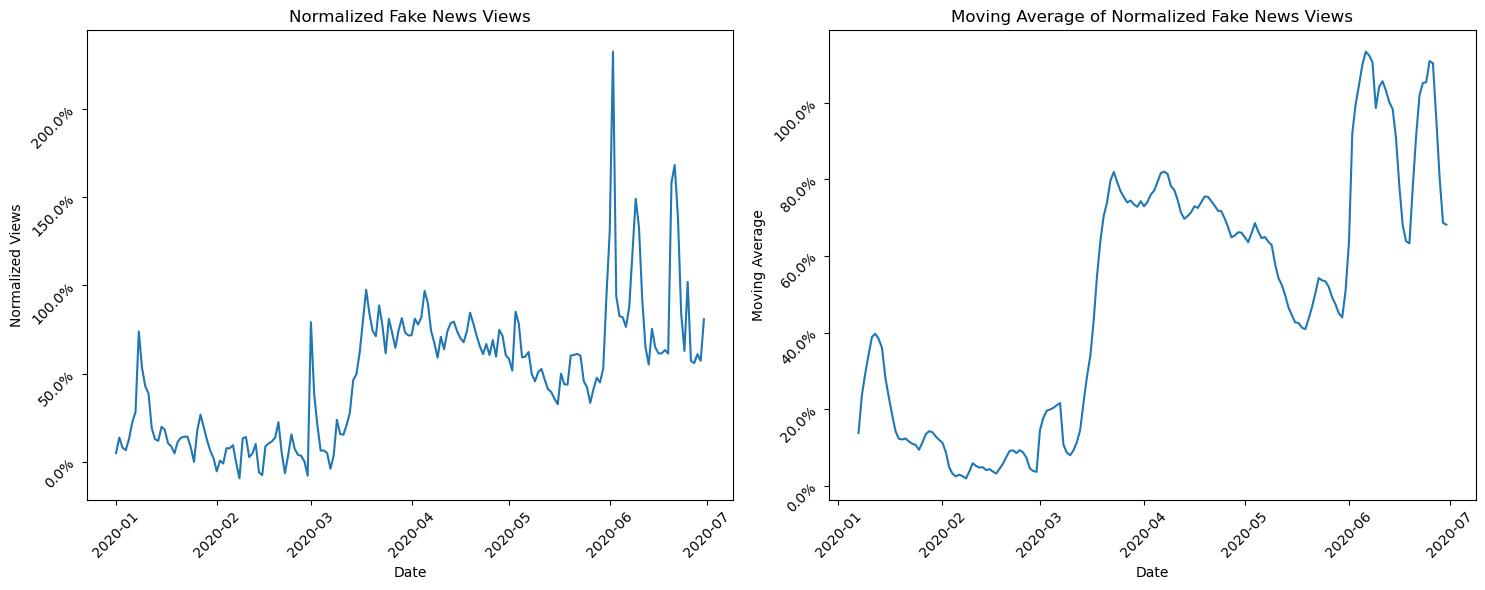

In [317]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot df_fake_dist_norm
axs[0].plot(df_fake_dist_norm['date'], df_fake_dist_norm['norm'])
axs[0].set_title('Normalized Fake News Views')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Normalized Views')
axs[0].tick_params(rotation=45)

# Format the y-axis tick labels as percentages with 1 decimal place
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))

# Plot moving average of df_fake_dist_norm
axs[1].plot(df_fake_dist_norm['date'], df_fake_dist_norm['moving_average'])
axs[1].set_title('Moving Average of Normalized Fake News Views')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Moving Average')
axs[1].tick_params(rotation=45)

# Format the y-axis tick labels as percentages with 1 decimal place
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))

plt.tight_layout()
plt.show()



# PART 0.1  Did the interest in fake news increase more than the global increase in wikipedia views!?

For this part we contructed the difference between the normalized increased in wikipedia views and the fake news increase in views.


Relative_Diff = %IncreaseWiki - %IncreaseWiki_fake news.


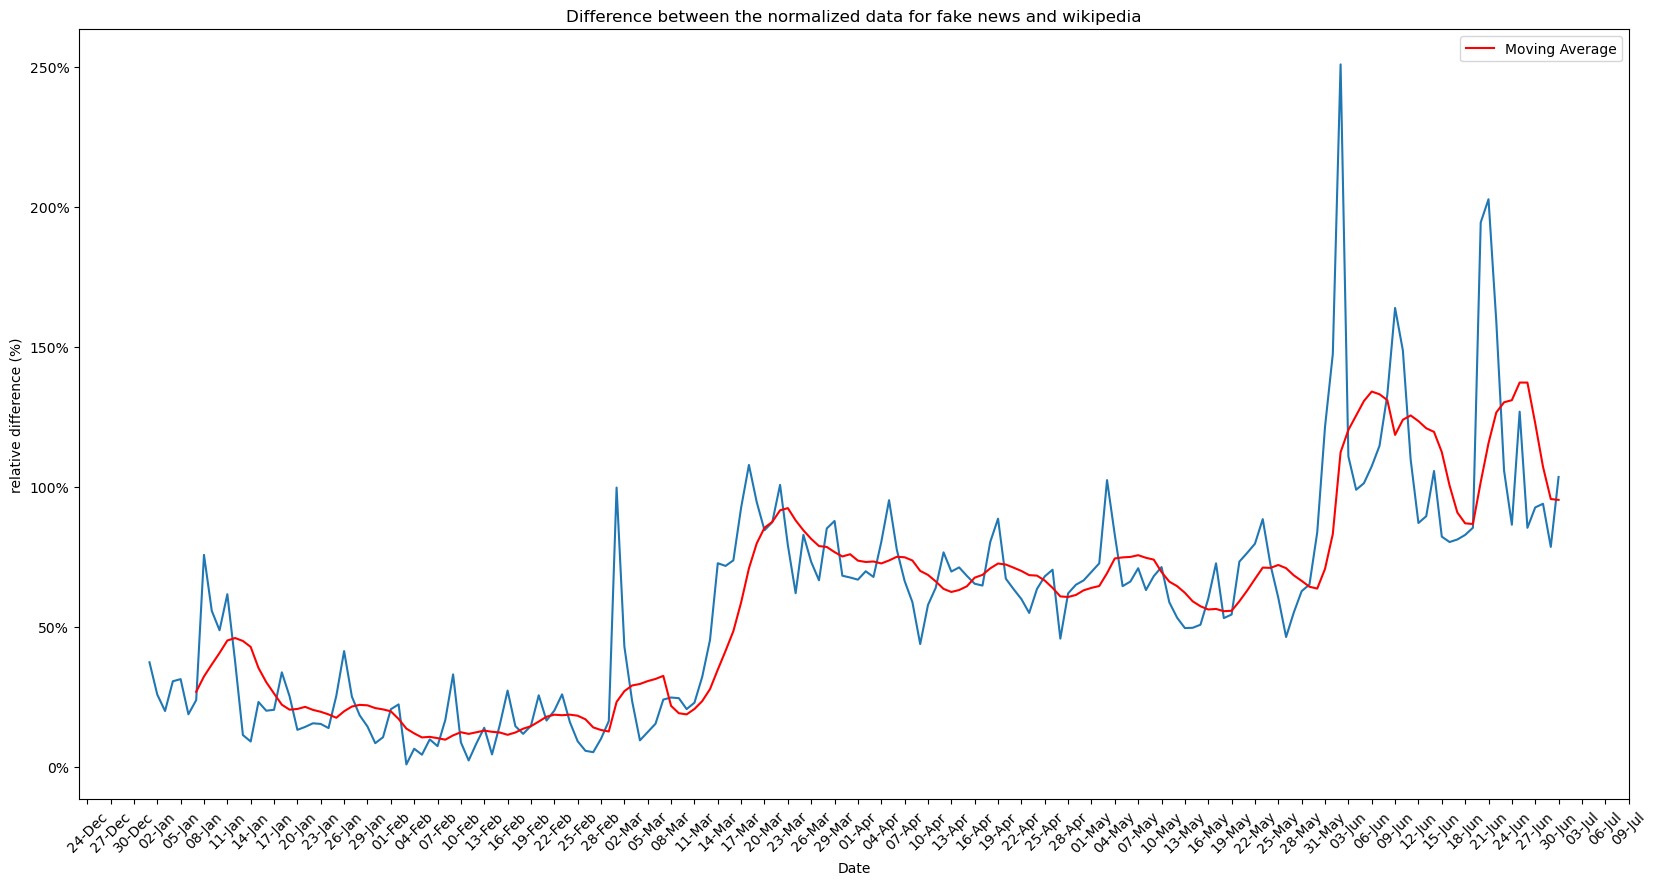

In [319]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

df_diff = pd.DataFrame({'date': df_fake_dist_norm['date'], 'sum_diff': df_fake_dist_norm['norm'] - df_wiki_dist_norm['norm']})


plt.figure(figsize=(20,10))
plt.plot(df_diff['date'], df_diff['sum_diff'])
plt.plot(df_diff['date'], df_diff['sum_diff'].rolling(window=7).mean(), color='red', label='Moving Average')  # Add the moving average line
plt.title('Difference between the normalized data for fake news and wikipedia')
plt.xlabel('Date')
plt.ylabel('relative difference (%)')  # Modify the y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set the x-axis tick interval to show every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Format the x-axis tick labels to show day and month
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Set the y-axis tick labels as percentages
plt.legend()  # Add a legend to show the moving average line
plt.show()





### Let's check for a statistical difference in the relative increase in fake news interest.

To check that we separate the data in two groups. A control group consisting of the normalized views 65 days before the lock down and the treatment group with the normalized increase 65 days during the lockdown (the full length of the lockdown).

Then we do a linear regression to quatify the extend of the difference and if it is statistically significant!

In [320]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import Timedelta 


# Filter data for 65 days before and after March 14, 2020
start_date = treatment_start_date - pd.Timedelta(days=65)

# control group data
df_control = df_diff[(df_diff['date'] <= treatment_start_date) & (df_diff['date'] >= start_date)]
df_control.reset_index(drop=True, inplace=True)

# treatment group data
df_treatment = df_diff[(df_diff['date'] >= treatment_start_date) & (df_diff['date'] <= treatment_end_date)]
df_treatment.reset_index(drop=True, inplace=True)

# Add treatment and post-treatment columns
df_treatment['treatment'] = 1
df_control ['treatment'] = 0

df_concatenated = pd.concat([df_control, df_treatment], ignore_index=True)

# Fit the model
model = smf.ols(formula='sum_diff ~ treatment', data=df_concatenated).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               sum_diff   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     294.1
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.72e-35
Time:                        19:51:36   Log-Likelihood:                 54.342
No. Observations:                 133   AIC:                            -104.7
Df Residuals:                     131   BIC:                            -98.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2225      0.020     11.155      0.0

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_22356\2780786776.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_22356\2780786776.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



R-squared =  0.692 and p-value < 0.05, coefficeint = 0.4819.
Their is around a 50% increase interest in fake news and it is statisticallly significant (we canr reject the null hypothesis)


Let's plot a box plot to visualize our results.

In [324]:
import plotly.express as px
df_combined = pd.concat([df_control, df_treatment])
df_combined['sum_diff'] = df_combined["sum_diff"]
df = df_combined

# Create a new column 'Group' with values 'Before lockdown' for control group and 'In lockdown' for treatment group
df['Group'] = ['Before lockdown'] * len(df_control) + ['In lockdown'] * len(df_treatment)

fig = px.box(df, x='Group', y='sum_diff', color="Group")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default

fig.update_layout(
    yaxis=dict(
        tickformat=".0%",  # Set the tick format to display as percentage
        title="Increase (%)",  # Set the y-axis title
    ),
    height=600,  # Adjust the height to make the figure taller
    width=600,   # Adjust the width to make the figure thinner
)

fig.show()

import plotly.io as pio

# Save the figure as an HTML file
pio.write_html(fig, file='figure.html', auto_open=False)



### We clearly see an increase in the median value of more than 40%. And their is nearly no overlap between the boxplots

# Part 0.2 : Categories of fake news increased during the lockdown

#So we plot pie charts showing the proportion of all news categories before, during and after the lockdown

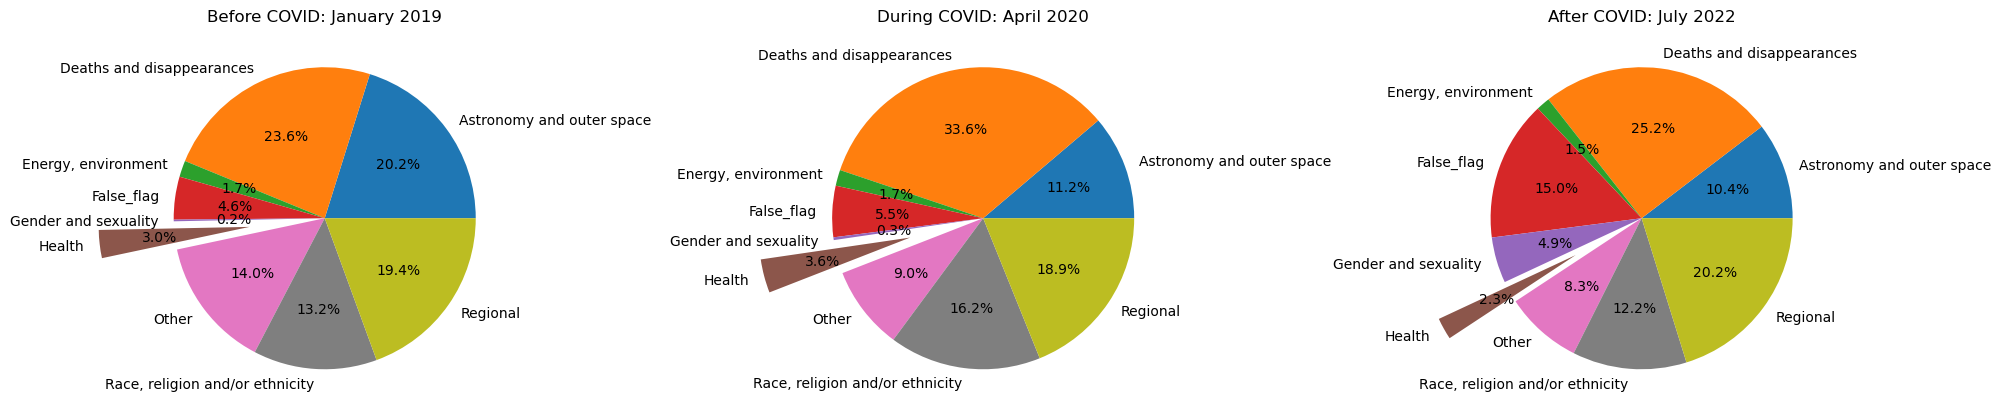

<Figure size 640x480 with 0 Axes>

In [334]:
plt.figure(figsize=(20, 10))

# Plot 1st pie chart
plt.subplot(1, 3, 1)  # Change the subplot parameters to (1, 3, 1)
explode = [0.5 if i == health_category_index else 0 for i in range(len(aggregated_data))]
plt.pie(aggregated_data.iloc[:, 1], labels=aggregated_data.index, autopct='%1.1f%%', startangle=0, explode=explode, labeldistance=1.1)
plt.title('Before COVID: January 2019')

# Plot 2nd pie chart
plt.subplot(1, 3, 2)  # Change the subplot parameters to (1, 3, 2)
explode = [0.5 if i == health_category_index else 0 for i in range(len(aggregated_data))]
plt.pie(aggregated_data.iloc[:, 90], labels=aggregated_data.index, autopct='%1.1f%%', startangle=0, explode=explode, labeldistance=1.1)
plt.title('During COVID: April 2020')

# Plot 3rd pie chart
plt.subplot(1, 3, 3)  # Change the subplot parameters to (1, 3, 3)
explode = [0.5 if i == health_category_index else 0 for i in range(len(aggregated_data))]
plt.pie(aggregated_data.iloc[:, 150], labels=aggregated_data.index, autopct='%1.1f%%', startangle=0, explode=explode, labeldistance=1.1)
plt.title('After COVID: July 2022')

plt.tight_layout()
plt.show()

plt.savefig('pie_chart.png')



### There is a visible increase in health related fake news this might be because of the increase in fake news related to Covid.
However a lot of wikipedia pages linked to Covid fake news didn't exist at the time. So, we need another database to go more in depth...


# Part 0.3 : How much did the Covid related fake news increased during the lockdown.

### The following database regroups all the pertinent links related to wikipedia article related with Covid fake news. An increase in the views of this pages would represent an increase interest in Covid fake news.

The following codes download and cleans the database. Then normalize it and plots the relative increase in Covid fake news interest compared with the 2018 baseline for the same articles.
Like before.



In [154]:
source  = "Data/"
wiki_pages_links = pd.read_csv(source+"covid-19_misinformation5.csv").copy()
language = "en"
articles_list = ["Covid-19"]
result=fetch_pageview_count(language, articles_list)


import ast
wiki_pages_links = pd.read_csv(source+"covid-19_misinformation5.csv").copy()

#Filtering misinformation with the selected clusters
word_cluster_1= "Virus origin" 
word_cluster_2= "Disease spread"
word_cluster_3= "Prevention and treatment"
word_cluster_4= "Mortality"
word_cluster_5= "Other"

wiki_cluster_links_1 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_1))].copy()
wiki_cluster_links_2 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_2))].copy()
wiki_cluster_links_3 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_3))].copy()
wiki_cluster_links_4 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_4))].copy()
wiki_cluster_links_5 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_5))].copy()

# Cleaning the clusters to only obtain words searcheable in wikipedia API
def extract_clean_text(links):
    cleaned_links = []
    for link in links:
        if '/wiki/' in link:
            extracted_text = link.split('/wiki/')[1].split('#')[0].replace('_', ' ')
            cleaned_links.append(extracted_text)
    return cleaned_links

# Convert string representation of list to actual list using ast.literal_eval and apply the function

wiki_cluster_links_1["Cleaned_Text"] = wiki_cluster_links_1["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_2["Cleaned_Text"] = wiki_cluster_links_2["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_3["Cleaned_Text"] = wiki_cluster_links_3["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_4["Cleaned_Text"] = wiki_cluster_links_4["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_5["Cleaned_Text"] = wiki_cluster_links_5["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))

# Looking for all the articles in the cluster 1 which correspond to Virus Origin 

list_cluster_1 = list(wiki_cluster_links_1["Cleaned_Text"])
list_cluster_2 = list(wiki_cluster_links_2["Cleaned_Text"])
list_cluster_3 = list(wiki_cluster_links_3["Cleaned_Text"])
list_cluster_4 = list(wiki_cluster_links_4["Cleaned_Text"])
list_cluster_5 = list(wiki_cluster_links_5["Cleaned_Text"])
language      = "en"
final_count_1 =[]
for i in list_cluster_1:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_1.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 2 which correspond to Spread

list_cluster_2 = list(wiki_cluster_links_2["Cleaned_Text"])
del list_cluster_2[7] # Outlier - this element has an empty list that doesn't allow to concatenate the data frame
final_count_2 =[]
for i in list_cluster_2:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_2.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 3 which correspond to Prevention and Treatment
list_cluster_3 = list(wiki_cluster_links_3["Cleaned_Text"])
final_count_3 =[]
for i in list_cluster_3:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_3.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 4 which correspond to Mortality
list_cluster_4 = list(wiki_cluster_links_4["Cleaned_Text"])
final_count_4 =[]
for i in list_cluster_4:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_4.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 5 which correspond to Other
list_cluster_5 = list(wiki_cluster_links_5["Cleaned_Text"])
final_count_5 =[]
for i in list_cluster_5:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_5.append(pd.DataFrame(merged_df))







Error fetching dateee for COVID-19 lab leak theory. Status Code: 404
Error fetching dateee for Li-Meng Yan. Status Code: 404
Error fetching dateee for Gain-of-function research. Status Code: 404
Error fetching dateee for Ralph Baric. Status Code: 404
Error fetching dateee for Chimeric virus. Status Code: 404
Error fetching dateee for COVID-19 misinformation by China. Status Code: 404
Error fetching dateee for 2022 Russian invasion of Ukraine. Status Code: 404
Error fetching dateee for 2022 German coup d%27%C3%A9tat plot. Status Code: 404
Error fetching dateee for Anti-vaccine activism. Status Code: 404
Error fetching dateee for Mark Steele (conspiracy theorist). Status Code: 404
Error fetching dateee for Kate Shemirani. Status Code: 404
Error fetching dateee for Lidia Morawska. Status Code: 404
Error fetching dateee for 5G misinformation. Status Code: 404
Error fetching dateee for Logically (company). Status Code: 404


### Plotting the relative increase of Covid-19 fake news related article.

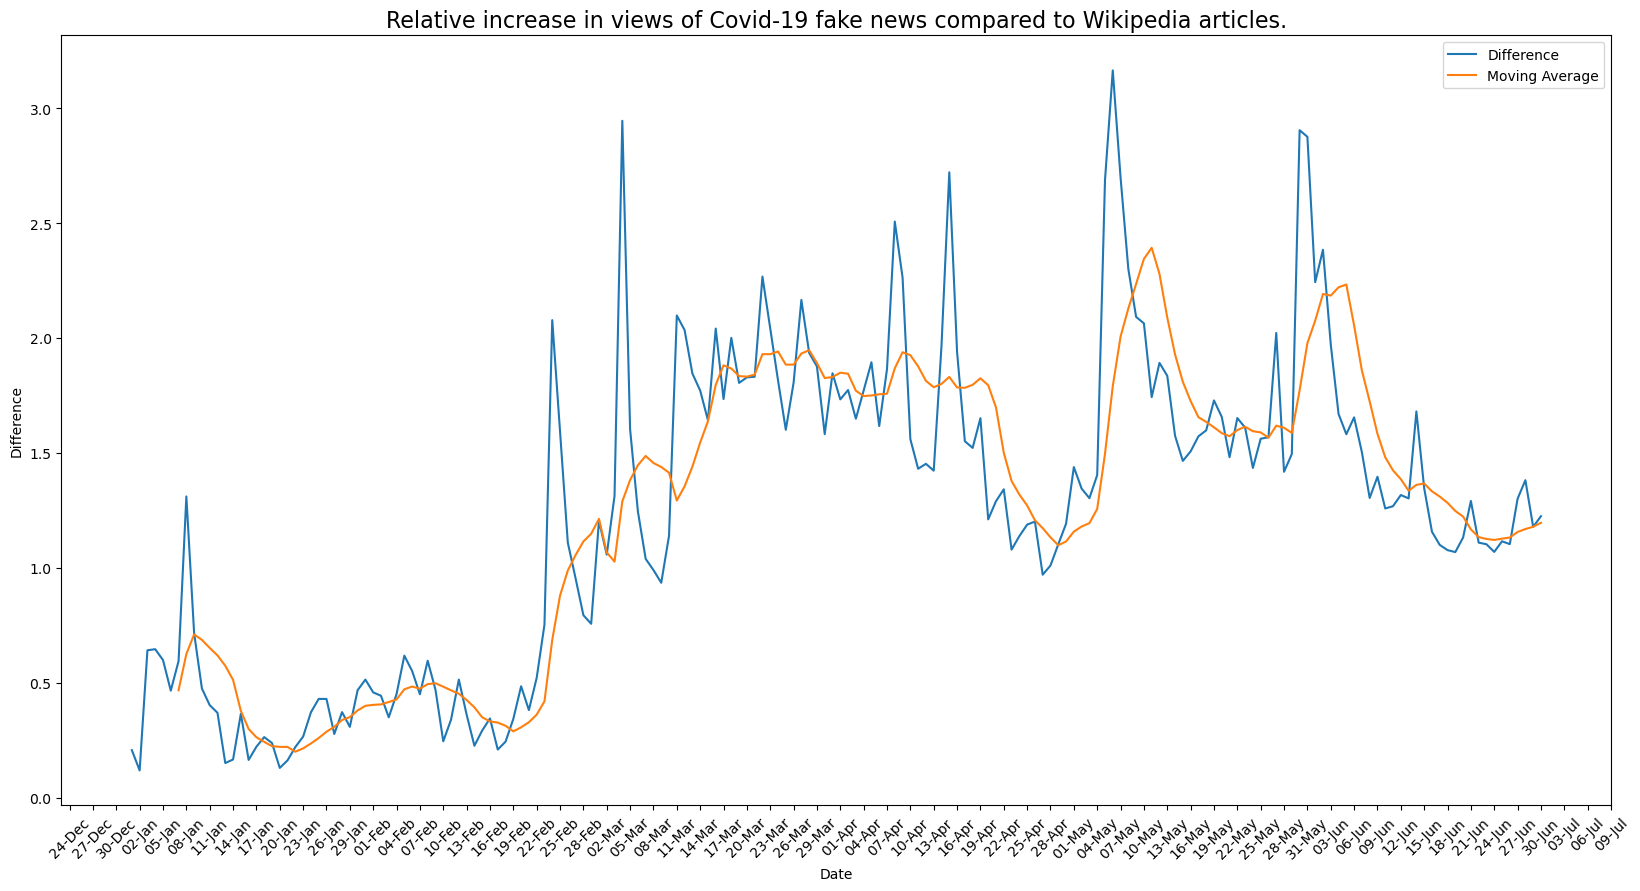

In [327]:
#concatenating the dataframes of each cluster

if final_count_1:
    final_views_1 = pd.concat(final_count_1, ignore_index=False)
else:
    final_views_1 = pd.DataFrame()

if final_count_2:
    final_views_2 = pd.concat(final_count_2, ignore_index=False)
else:
    final_views_2 = pd.DataFrame()

if final_count_3:
    final_views_3 = pd.concat(final_count_3, ignore_index=False)
else:
    final_views_3 = pd.DataFrame()

if final_count_4:
    final_views_4 = pd.concat(final_count_4, ignore_index=False)
else:
    final_views_4 = pd.DataFrame()

if final_count_5:
    final_views_5 = pd.concat(final_count_5, ignore_index=False)
else:
    final_views_5 = pd.DataFrame()

# Grouping the new data frame to get the final number of visits
data_1 = final_views_1.groupby(['timestamp']).sum()
data_2 = final_views_2.groupby(['timestamp']).sum()
#data_3 = final_views_3.groupby(['timestamp']).sum()
#data_4 = final_views_4.groupby(['timestamp']).sum()
data_5 = final_views_5.groupby(['timestamp']).sum()

df = pd.DataFrame()
df['views'] = data_1['views'] + data_2['views'] + data_5['views']
df_covid = df.copy()
df_covid.reset_index(inplace=True)
df_covid.columns = ['date', 'sum']


mask_2020 = (df_covid['date'] >= start_jan_2020) & (df_covid['date'] <= end_june_2020)
df_covid_2020 = df_covid.loc[mask_2020]
df_covid_2020.reset_index(drop=True, inplace=True)

#distance to normality off 2020 wiki compared to average values of 2018
mask_2018 = (df_covid['date'] >= start_jan_2018) & (df_covid['date'] <= end_june_2018)
df_covid_2018 = df_covid.loc[mask_2018]
df_covid_2018.reset_index(drop=True, inplace=True)
# Normalize Covid fake news
mean = df_covid_2018['sum'].mean()
df_covid_normalized = (df_covid_2020['sum'] - mean) / mean


# Create a new dataframe with columns 'date' and 'norm'
df_normalized = pd.DataFrame({'date': df_covid_2020['date'], 'sum': df_covid_normalized})

#plot the percentage of increase interest in Covid-19 fake news relative to wikipedia baseline
df_diff_covid = pd.DataFrame({'date': df_covid_2020['date'], 'sum_diff': df_normalized['sum'] - df_wiki_dist_norm['norm']})


# Calculate the moving average
window_size = 7
moving_average = df_diff_covid['sum_diff'].rolling(window_size).mean()

# Plot the difference and the moving average
plt.figure(figsize=(20,10))
plt.plot(df_diff_covid['date'], df_diff_covid['sum_diff'], label='Difference')
plt.plot(df_diff_covid['date'], moving_average, label='Moving Average')
plt.title('Relative increase in views of Covid-19 fake news compared to Wikipedia articles.',fontsize=16)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.legend()
plt.show()




### We use linear regression to check another  time the amount of increase and how significant it is.

In [223]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import Timedelta 
import seaborn as sns
import matplotlib.pyplot as plt


start_date = treatment_start_date - pd.Timedelta(days=65)  # 65 days before the beginning of lockdown
treatment_start_date  #beggining of lockdown 2020-03-16
treatment_end_date # Back to normal 2020-05-21

# control group data from 65 days before the beginning of lockdown to the beginning of lockdown
df_control_covid = df_diff_covid[(df_diff_covid['date'] <= treatment_start_date) & (df_diff_covid['date'] >= start_date)]
df_control_covid.reset_index(drop=True, inplace=True)

# treatment group data from the beginning of lockdown to the end of lockdown
df_treatment_covid = df_diff_covid[(df_diff_covid['date'] >= treatment_start_date) & (df_diff_covid['date'] <= treatment_end_date)]
df_treatment_covid.reset_index(drop=True, inplace=True)

# Add treatment and post-treatment columns
df_treatment_covid['treatment'] = 1
df_control_covid['treatment'] = 0

df_concatenated = pd.concat([df_control_covid, df_treatment_covid], ignore_index=True)

# Fit the model
model = smf.ols(formula='sum_diff ~ treatment', data=df_concatenated).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               sum_diff   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     116.3
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           8.50e-20
Time:                        17:32:04   Log-Likelihood:                -104.26
No. Observations:                 133   AIC:                             212.5
Df Residuals:                     131   BIC:                             218.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7289      0.066     11.090      0.0

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_22356\2638902545.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment_covid['treatment'] = 1
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_22356\2638902545.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control_covid['treatment'] = 0


### With an R-squared of 0.470, a P-value <0.05 and a coefficient of ~1. Wich means we have around a 100% increase in average and it can't be explained by the null hypothesis.

In [328]:
import plotly.express as px
df_combined = pd.concat([df_control_covid, df_treatment_covid])
df_combined['sum_diff'] = df_combined["sum_diff"]
df = df_combined

# Create a new column 'Group' with values 'Before lockdown' for control group and 'In lockdown' for treatment group
df['Group'] = ['Before lockdown'] * len(df_control) + ['In lockdown'] * len(df_treatment)

fig = px.box(df, x='Group', y='sum_diff', color="Group")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default

fig.update_layout(
    yaxis=dict(
        tickformat=".0%",  # Set the tick format to display as percentage
        title="Increase (%)",  # Set the y-axis title
    ),
    height=600,  # Adjust the height to make the figure taller
    width=600,   # Adjust the width to make the figure thinner
)

fig.show()

import plotly.io as pio

# Save the figure as an HTML file
pio.write_html(fig, file='figure.html', auto_open=False)



The boxplot visualy confirms that their is a big increase in Covid-19 fake news interest (the median increased by 100% ). 
Also the interquatile range of the box plot don't overlap.